# Model 1: Estimation of team strength parameters (Team data)

In [1]:
# Initialization
#loaded_pp_filename = 'teamdata2017_preprocessed'
#loaded_std_filename = 'teamdata2017_standardized'
#saved_filename = 'teamdata2017_strenghtparam'
loaded_pp_filename = 'teamdata2018_preprocessed'
loaded_std_filename = 'teamdata2018_standardized'
saved_filename = 'teamdata2018_strenghtparam'

## 0. Load libraries and define functions

### 0.1 General python functionality

In [2]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
import operator
import itertools
from numpy.random import choice
from collections import Counter
import statistics
from scipy import stats

# Functions used for data visualization
import seaborn as sns
sns.set(context = "paper", font = "monospace")
import matplotlib.pyplot as plt

In [3]:
# Special functions needed for custom functions
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, RidgeClassifierCV, LogisticRegression, ElasticNetCV, ElasticNet, Lasso, RidgeClassifier
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
# Surpress printing warnings
import warnings
warnings.filterwarnings("ignore")

### 0.2 Custom functions

In [5]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 20, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    
        plt.savefig('Barplot_' + title + '.png')

In [6]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()
    plt.savefig('Frequency_' + title + '.png')

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()
    plt.savefig('Boxplot_' + title + '.png')

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()
    plt.savefig('Probabilityplot_' + title + '.png')

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [7]:
### Function used to split the data into training and test data
def data_splitter(df, response_name = 'target', split_threshold = 0.15, seed = 42):
    """
    Function used to split a dataframe into test and training data
    
    param: df (Panda's dataframe object)
    param: response_name (string): The name of the response variable in the dataframe
    param: split_threshold (float): The split threshold used
    param: seed (int): Integer defining the seed for random split of the data
    
    return: (tuple) A tuple with four pandas dataframe objects
    """
    # Split the dataframe into features and response variable
    df_tmp = df.copy()
    x, y = df_tmp.drop([response_name], axis = 1), df[response_name]
    # Split the feature and response variable into training and test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = split_threshold, random_state = seed)
    return (x_train, x_test, y_train, y_test)

In [8]:
### Function used to generate a summary of the input model (binary classes)
def binary_class_evaluator(model, x_test, y_test, threshold = 0.5, elasticnet = False):
    """
    Function returning a tuple with sensitivity, specificity and AUC metrics for specific model
    
    param: model (model): The model we like to evaluate
    param: x_test (list): List of lists of numpy arrays
    param: y_test (list): Binary values indicating the outcome variable
    param: threshold (float): The classification threshold used
    param: elasticnet (bool): Booling indicator for specifying whether the model is elastic net based

    return: A tuple containing the calculated sensitivity, specificity and AUC metrics
    """
    # Calculate the different summary statistics based on the model and test data
    test_data =  list(y_test) 
    model_preds = list(model.predict(x_test)) if not elasticnet else [1.0 if x > 0 else 0.0 for x in model.predict(x_test)]
    model_acc = metrics.accuracy_score(test_data, model_preds)
    true_pos = len([mp for mp, td in zip(model_preds, test_data) if mp > threshold and td == 1])
    false_neg = len([mp for mp, td in zip(model_preds, test_data) if mp < threshold and td == 1])
    true_neg = len([mp for mp, td in zip(model_preds, test_data) if mp < threshold and td == 0])
    false_pos = len([mp for mp, td in zip(model_preds, test_data) if mp > threshold and td == 0])
    
    # Print intermediate summary to the user
    print("Based on a threshold of", threshold, "the following summary statistics can be obtained:\n", "-"*100)
    print(true_pos, "true positives over all positives (the wins that were correctly classified).")
    print(false_pos, "false positives (the wins that were wrongly classified).")
    print(true_neg, "true negatives (the losses that were correctly classified).")
    print(false_neg, "false negatives (the losses that were wrongly classified).\n")
    print("The sensitivity is: ", true_pos / (true_pos + false_neg))
    print("The specificity is: ", true_neg / (true_neg + false_pos))
    
    # Plot the ROC curve for the model
    print("\n\nAccuracy:", model_acc, "\n", "-"*100)
    fpr, tpr, _ = metrics.roc_curve(test_data, model_preds)
    auc = metrics.roc_auc_score(test_data, model_preds)
    plt.plot(fpr, tpr, label= "auc: " + str(round(auc, 4)))
    plt.legend(loc = 4)
    plt.title('ROC curve')
    plt.show()
    
    # Return sensitivity and specificity values to the user 
    return true_pos / (true_pos + false_neg), true_neg / (true_neg + false_pos), auc, model_acc

In [9]:
### Function used to plot the confusion matrix (normalization can be applied if desired)
def plot_confusion_matrix(model, x_test, y_test, classes, normalize = False, elasticnet = False, cmap = plt.cm.Blues):
    """
    Function that visualizes the confusion matrix based on the predictions made by the fitted model and their correspondence
    to the observed test data. The option is available to return the normalized confusion matrix.
    
    param: model (model): The model we like to evaluate
    param: x_test (list): List of lists of numpy arrays
    param: y_test (list): Binary values indicating the outcome variable
    param: classes (list): A list of classes that correspond to the numbered labels in the confusion matrix in that order.
    param: normalize (bool): Booling indicator for specification of returning the normalized or non-normalized confusion matrix.
    param: elasticnet (bool): Booling indicator for specifying whether the model is elastic net based
    """
    # Approximate the confusion matrix based on model predictions
    model_preds = list(model.predict(x_test)) if not elasticnet else [1.0 if x > 0 else 0.0 for x in model.predict(x_test)]
    cm = sklearn.metrics.confusion_matrix(y_test, model_preds)
    
    # Normalize the cm if desired
    title = 'Normalized confusion matrix' if normalize else 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create confusion matrix
    print(title, ":\n", "-"*100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
### Function used to extract the top10 most important features based on the magnitute of the coefficients
def important_features_extractor(model, fitted_features, top = 10, elasticnet = False):
    """
    Function used to extract a dictionary mapping the features used in the model with the estimates of their coefficients
    
    param: model (model): The model we like to evaluate.
    param: fitted_features (list): List capturing the different features evaluated by the model.
    param: top (int): The amount of fetaures you like to be printed as output (sorted based on decreasing importance).
    param: elasticnet (bool): Booling indicator for specifying whether the model is elastic net based
    return: (dict) A dictionary mapping the features with their corresponding coefficient estimates.
    """
    # Extract model coefficients
    coefficients = model.coef_[0] if not elasticnet else model.coef_
    coef_dict = {col:coef for col, coef in zip(fitted_features, coefficients)}
    coef_dict_abs = {col:abs(round(coef,2)) for col, coef in zip(fitted_features, coefficients)}
    sorted_coefs = sorted(coef_dict_abs.items(), key=operator.itemgetter(1), reverse= True)

    # Return the top ten most important features and their coefficients
    print("Summary of the important features and their corresponding coefficients:\n", '-'*100)
    ret_dict = dict()
    for index, (col, abs_score) in enumerate(sorted_coefs):
        if index < top:
            print(col, ':', coef_dict[col])
        ret_dict[col] = coef_dict[col]
    return ret_dict

In [11]:
### Function used to draw a random sample from the discrete distribution of probabilities representing the input list
def RandomSampleProbDist(list_of_values, draws = 1):
    """
    :param: list_of_values (list): A list of categorical values representing the observations in the dataset
    :param: draws (int): The number of samples desired to be returned
    :return: (array) An array capturing the sampled categories
    """
    # Only the non-missing values are considered in the sampling procedure
    non_missing_list = list_of_values.dropna()
    # Sample from the discrete probability distribution representing the categorical variable
    return list(choice(list(Counter(non_missing_list)), 
                  draws, 
                  p = list(map(lambda x: x/len(non_missing_list), 
                               Counter(non_missing_list).values()))))[0]

## 1. Load preprocessed data in environment

### 1.1 Load standardized data

In [12]:
# Load pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + loaded_std_filename + '.pickle', 'rb') as f:
    data_raw = pickle.load(f)

In [13]:
# Visualize data
data_raw

,split,patchno,gamelength,k,d,a,teamkills,fbtime,kpm,ckpm,...,Encoded_fd,Encoded_herald,Encoded_ft,Encoded_firstmidouter,Encoded_firsttothreetowers,Encoded_fbaron,Encoded_Year,Encoded_culture,team,result
0,-0.090416,-0.789673,0.743053,-0.104260,0.048026,-0.289877,-0.104260,0.656016,-0.317071,-0.305625,...,0.805193,-0.621682,-1.245372,1.245372,-0.802973,-1.277857,-0.927961,1.295818,mvp,0.0
1,-0.090416,-0.789673,0.743053,0.050891,-0.106979,0.310268,0.050891,0.656016,-0.188847,-0.305625,...,-1.241938,-0.621682,0.802973,-0.802973,1.245372,0.782560,-0.927961,1.295818,jin air green wings,1.0
2,-0.090416,-0.789673,-0.754466,-1.035167,0.668045,-1.250108,-1.035167,-0.221053,-0.856724,0.288867,...,-1.241938,-0.621682,-1.245372,-0.802973,-0.802973,-1.277857,-0.927961,1.295818,jin air green wings,0.0
3,-0.090416,-0.789673,-0.754466,0.671495,-1.037009,0.370282,0.671495,-0.221053,1.059069,0.288867,...,0.805193,-0.621682,0.802973,1.245372,1.245372,0.782560,-0.927961,1.295818,mvp,1.0
4,-0.090416,-0.789673,0.635335,0.671495,-0.571994,1.150470,0.671495,-0.054878,0.372753,-0.127091,...,0.805193,-0.621682,-1.245372,-0.802973,1.245372,-1.277857,-0.927961,1.295818,mvp,1.0
5,-0.090416,-0.789673,0.635335,-0.569714,0.668045,-0.950036,-0.569714,-0.054878,-0.677393,-0.127091,...,-1.241938,-0.621682,0.802973,1.245372,-0.802973,0.782560,-0.927961,1.295818,jin air green wings,0.0
6,-0.090416,-0.789673,0.535996,1.292099,-0.726999,0.670355,1.292099,0.971902,0.954676,0.260410,...,0.805193,-0.621682,-1.245372,1.245372,1.245372,0.782560,-0.927961,1.295818,longzhu gaming,1.0
7,-0.090416,-0.789673,0.535996,-0.724865,1.288065,-0.769992,-0.724865,0.971902,-0.788764,0.260410,...,-1.241938,-0.621682,0.802973,-0.802973,-0.802973,-1.277857,-0.927961,1.295818,kt rolster,0.0
8,-0.090416,-0.789673,-0.322816,-1.345469,0.048026,-1.310123,-1.345469,0.924970,-1.247195,-0.840134,...,-1.241938,1.608540,-1.245372,-0.802973,1.245372,-1.277857,-0.927961,1.295818,kt rolster,0.0
9,-0.090416,-0.789673,-0.322816,0.050891,-1.347018,0.130225,0.050891,0.924970,0.193837,-0.840134,...,0.805193,-0.621682,0.802973,1.245372,-0.802973,0.782560,-0.927961,1.295818,longzhu gaming,1.0


In [14]:
# Check all values are numeric
print("Set of the different column types captured by the data: ", set(data_raw.dtypes))
# Check no missing data
print("The number of missing values in the data: ", sum(data_raw.isnull().any()))

Set of the different column types captured by the data:  {dtype('O'), dtype('float64')}
The number of missing values in the data:  0


## 2. Split data in test and train data

In [15]:
# Create copy of data for model building (removing team feature)
data = data_raw.copy()
data = data.drop(labels = ['team', 'split', 'patchno', 'gamelength', 'Encoded_Year', 'Encoded_culture'], axis=1)

In [16]:
# Split the data
x_train, x_test, y_train, y_test = data_splitter(data, 'result')

In [17]:
# Check data is standardized and centered
print("The data is centered: ", 
      all([int(x) for x in round(x_train.mean(axis = 0), 4)]) == 0,
     "\nThe data is standardized: ",
      all([int(x) for x in round(x_train.var(axis = 0), 4)]) == 1)

The data is centered:  True 
The data is standardized:  False


## 3. Model creation

In [18]:
# Create dictionary to capture model summary
logistic_L1penalty_model_dict, ridge_model_dict, elasticnet_model_dict, rf_model_dict, model_summary_dict = dict(), dict(), dict(), dict(), dict()

### 3.1 Logistic regression with L1 penalty (Lasso classification model)
Here, the recursive feature elimination techinique is used to initialize L1 penalization in our logistic regression model and hence allows implementation of lasso regularization.

##### Recursive feature elimination
Given an external estimator that assigns weights to features (~coefficients), the goal of recursive feature elimination is to select features by recursively considering smaller and smaller sets of features. The estimator is trained on the initial set of features and the importance of each feature is obtained. Based on this information the least important features are pruned from the current set of features. This procedure is recursively repeated on the pruned set until the desired number of features to select is reached. To get the optimal number of features CV is used.

In [19]:
# By using the liblinear solver the L1 penalty is implemented
logreg = LogisticRegression(solver='liblinear')
rfe = RFECV(logreg, cv = 5)
rfe = rfe.fit(x_train, y_train)

In [20]:
# Intermediate summary
selected_features_rfe = [col for col, bool_importance in zip(x_train.columns.values, rfe.support_) if bool_importance]
print("Based on the recursive elimination method the following", len(selected_features_rfe),
      "features are selected: ", selected_features_rfe)

Based on the recursive elimination method the following 27 features are selected:  ['d', 'a', 'teamkills', 'kpm', 'ckpm', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'dmgtochampsperminute', 'wards', 'wardkills', 'visionwardbuys', 'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'cspm', 'goldat15', 'gdat15', 'xpat10', 'csat10', 'csdat15', 'Encoded_fbaron']


Remark: The solver used by the logistic regression model is 'liblinear' which applies automatic parameter selection (L1 regularization) and is recommended when using a high dimensional dataset.

##### Model fit

In [21]:
# Fit the logistic regression model
logistic_L1penalty_model = LogisticRegression(solver='liblinear')
fitted_logistic_L1penalty_model = logistic_L1penalty_model.fit(x_train[selected_features_rfe], y_train)

# Save best approximation alpha after CV
logistic_L1penalty_model_dict['regularisation_param'] = np.nan

##### Model accuracy evaluation

Based on a threshold of 0.5 the following summary statistics can be obtained:
 ----------------------------------------------------------------------------------------------------
860 true positives over all positives (the wins that were correctly classified).
20 false positives (the wins that were wrongly classified).
815 true negatives (the losses that were correctly classified).
14 false negatives (the losses that were wrongly classified).

The sensitivity is:  0.9839816933638444
The specificity is:  0.9760479041916168


Accuracy: 0.9801053247513165 
 ----------------------------------------------------------------------------------------------------


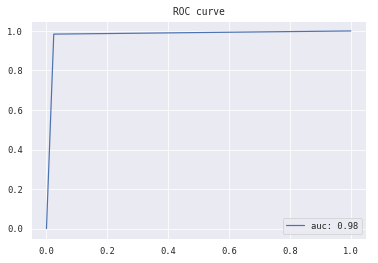

Confusion matrix :
 ----------------------------------------------------------------------------------------------------


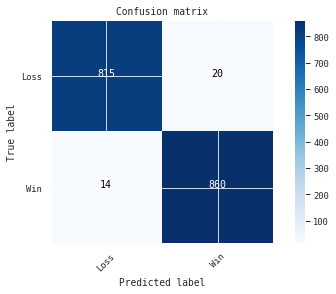

Normalized confusion matrix :
 ----------------------------------------------------------------------------------------------------


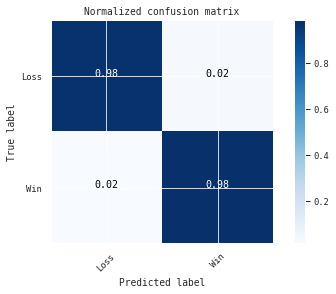

In [22]:
# Model accuracy evaluation metrics
logistic_L1penalty_model_dict['sensitivity'], logistic_L1penalty_model_dict['specificity'], logistic_L1penalty_model_dict['auc'], logistic_L1penalty_model_dict['accuracy'] = binary_class_evaluator(fitted_logistic_L1penalty_model, x_test[selected_features_rfe], y_test)

# Plot non-normalized and normalized confusion matrix
plot_confusion_matrix(fitted_logistic_L1penalty_model, x_test[selected_features_rfe], y_test, classes=['Loss', 'Win'])
plot_confusion_matrix(fitted_logistic_L1penalty_model, x_test[selected_features_rfe], y_test, classes=['Loss', 'Win'], normalize=True)

##### Feature importance evaluator

In [23]:
# Show the sorted features indicating the highest importance in predicting the target
logistic_L1penalty_model_dict['feature_importance'] = important_features_extractor(fitted_logistic_L1penalty_model, selected_features_rfe)

Summary of the important features and their corresponding coefficients:
 ----------------------------------------------------------------------------------------------------
teamtowerkills : 5.147349233949684
d : -1.9480098475526517
earnedgpm : 1.8163439581061713
kpm : 1.7855895720593788
gspd : -1.16113794655408
goldspent : -0.9966583903732464
monsterkillsownjungle : 0.9885635700893772
totalgold : -0.8322207138915909
monsterkills : -0.8107265251415631
a : 0.6723483384823555


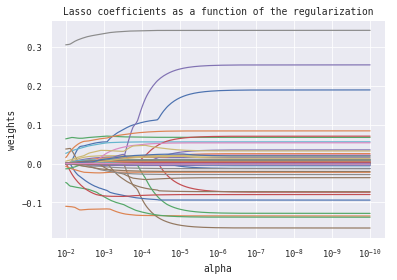

In [24]:
# Visualize the use of different regularization parameters on coefficient estimates for Lasso regression
n_alphas, coefs = 200, []
alphas = np.logspace(-10, -2, n_alphas)
for a in alphas:
    lasso = Lasso(alpha = a, fit_intercept = False)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

# Visualize the regularization curve
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### 3.2 Ridge classification model
Ridge regression covers a machine learning technique that solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

To fit the ridge classification model the ridge classifier with build in cross-validation estimator is used from the sklearn package. The CV classifier allows us to evaluate different regularization parameters. Here, the array of alpha values that is explored ranges from 0.1 to 1. in steps of 0.025.

If the alpha value is 0, a OLS model seems to best fit the data. So, the smaller the value of alpha, the higher the magnitude of the coefficients. No intercept is calculated for the model, because the data is centered.

##### Model fit

In [25]:
# Fit the regression model for the optimal alpha 
alphas = np.arange(0.0, 1.0, 0.025)
ridge_model = RidgeClassifierCV(alphas, fit_intercept= False, cv= 5)
fitted_ridge_model = ridge_model.fit(x_train, y_train)

# Save best approximation alpha after CV
ridge_model_dict['regularisation_param'] = fitted_ridge_model.alpha_

##### Model accuracy evaluation

Based on a threshold of 0.5 the following summary statistics can be obtained:
 ----------------------------------------------------------------------------------------------------
868 true positives over all positives (the wins that were correctly classified).
23 false positives (the wins that were wrongly classified).
812 true negatives (the losses that were correctly classified).
6 false negatives (the losses that were wrongly classified).

The sensitivity is:  0.9931350114416476
The specificity is:  0.9724550898203593


Accuracy: 0.9830310122878877 
 ----------------------------------------------------------------------------------------------------


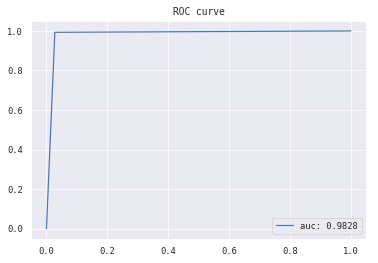

Confusion matrix :
 ----------------------------------------------------------------------------------------------------


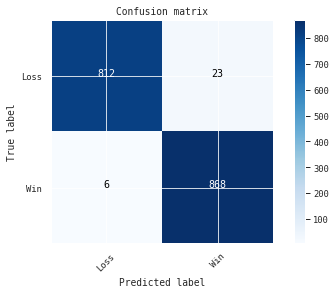

Normalized confusion matrix :
 ----------------------------------------------------------------------------------------------------


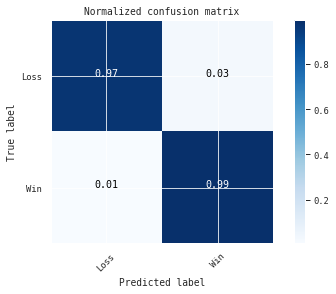

In [26]:
# Model accuracy evaluation metrics
ridge_model_dict['sensitivity'], ridge_model_dict['specificity'], ridge_model_dict['auc'], ridge_model_dict['accuracy'] = binary_class_evaluator(fitted_ridge_model, x_test, y_test)

# Plot non-normalized and normalized confusion matrix
plot_confusion_matrix(fitted_ridge_model, x_test,y_test, classes=['Loss', 'Win'])
plot_confusion_matrix(fitted_ridge_model, x_test,y_test, classes=['Loss', 'Win'], normalize=True)

##### Feature importance evaluator

In [27]:
# Show the sorted features indicating the highest importance in predicting the target
ridge_model_dict['feature_importance'] = important_features_extractor(fitted_ridge_model, x_train.columns.values)

Summary of the important features and their corresponding coefficients:
 ----------------------------------------------------------------------------------------------------
teamtowerkills : 0.6682372630983063
wardkills : 0.46938715002547726
wcpm : -0.30832549148588456
d : -0.28020108358164214
goldspent : -0.28104235433770947
wards : -0.19249102056829143
totalgold : -0.191119219529003
earnedgpm : 0.18023106211440565
gspd : -0.1610683432453399
kpm : -0.14586519871701414


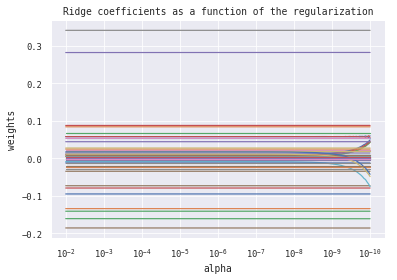

In [28]:
# Visualize the use of different regularization parameters on coefficient estimates for Ridge regression
n_alphas, coefs = 200, []
alphas = np.logspace(-10, -2, n_alphas)
for a in alphas:
    ridge = Ridge(alpha = a, fit_intercept = False)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)

# Visualize the regularization curve
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### 3.3 Elastic net classification model
The elastic net classification model will combine the L1 and L2 priors illustrated above in the same logistic regression model as regularizers. The ElasticNetCV function from sklearn allows us to play around with these regularization parameters by defining a range for the l1_ratio = a/ (a + b), where  a * L1 + b * L2 composes the penalization term. If the optimal l1_ratio parameter is closer to 1, a sparser selection is managed, while l1_ratio parameters close to 0 result in more shrinkage of the coefficients.

##### Model fit

In [29]:
# Fit the elasticnet classification model
l1_ratios = alphas[1:]
elasticnet_model = ElasticNetCV(l1_ratio = l1_ratios, fit_intercept= False, cv= 5, random_state=0)
fitted_elasticnet_model = elasticnet_model.fit(x_train, y_train)

# Save best approximation alpha after CV
elasticnet_model_dict['regularisation_param'] = {'l1_ratio': fitted_elasticnet_model.l1_ratio_,
                                                 'alpha': fitted_elasticnet_model.alpha_}

##### Model accuracy evaluation

Based on a threshold of 0.5 the following summary statistics can be obtained:
 ----------------------------------------------------------------------------------------------------
866 true positives over all positives (the wins that were correctly classified).
24 false positives (the wins that were wrongly classified).
811 true negatives (the losses that were correctly classified).
8 false negatives (the losses that were wrongly classified).

The sensitivity is:  0.9908466819221968
The specificity is:  0.9712574850299401


Accuracy: 0.981275599765945 
 ----------------------------------------------------------------------------------------------------


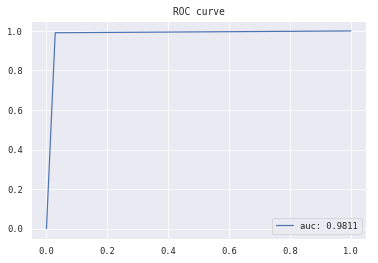

Confusion matrix :
 ----------------------------------------------------------------------------------------------------


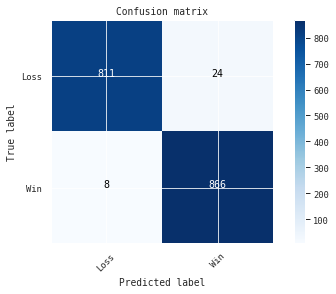

Normalized confusion matrix :
 ----------------------------------------------------------------------------------------------------


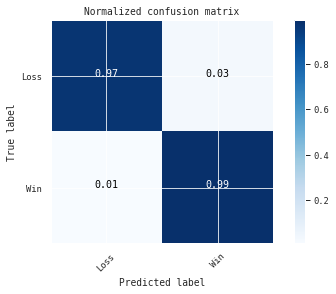

In [30]:
# Model accuracy evaluation metrics
elasticnet_model_dict['sensitivity'], elasticnet_model_dict['specificity'], elasticnet_model_dict['auc'], elasticnet_model_dict['accuracy'] = binary_class_evaluator(fitted_elasticnet_model, x_test, y_test, elasticnet = True)

# Plot non-normalized and normalized confusion matrix
plot_confusion_matrix(fitted_elasticnet_model, x_test, y_test, classes=['Loss', 'Win'], elasticnet = True)
plot_confusion_matrix(fitted_elasticnet_model, x_test, y_test, classes=['Loss', 'Win'], normalize=True, elasticnet = True)

##### Feature importance evaluator

In [31]:
# Show the sorted features indicating the highest importance in predicting the target
elasticnet_model_dict['feature_importance'] = important_features_extractor(fitted_elasticnet_model, 
                                                                           x_train.columns.values, 
                                                                           elasticnet = True)

Summary of the important features and their corresponding coefficients:
 ----------------------------------------------------------------------------------------------------
teamtowerkills : 0.27300611869720404
d : -0.1265505792889687
goldspent : -0.07170190810962107
a : 0.06181332547229792
earnedgpm : 0.05979739226983014
gspd : -0.059270299263037875
teambaronkills : 0.053064497445683825
k : 0.02891308436015938
teamkills : 0.028623876954144936
totalgold : -0.034735018873928186


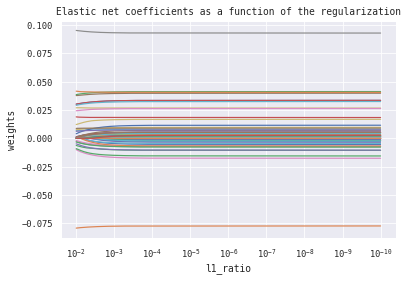

In [32]:
# Visualize the use of different regularization parameters on coefficient estimates for Ridge regression
n_ratios, coefs = 200, []
l1_ratios = np.logspace(-10, -2, n_ratios)
for r in l1_ratios:
    elasticnet = ElasticNet(l1_ratio = r, fit_intercept = False)
    elasticnet.fit(x_train, y_train)
    coefs.append(elasticnet.coef_)

# Visualize the regularization curve
ax = plt.gca()
ax.plot(l1_ratios, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('l1_ratio')
plt.ylabel('weights')
plt.title('Elastic net coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### 3.4 Random Forests classifier

##### Model fit

In [33]:
# Define hyperparameter grid
param_grid = {'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt'],
              'n_estimators': [200, 1000, 2000]}

# Hyperparametertuning of the Random Forest model (cv = 5 folds)
rf_model = RandomForestClassifier()
grid_rf_model = GridSearchCV(rf_model, param_grid, cv=5)
grid_best_rf_model = grid_rf_model.fit(x_train, y_train)

# Save optimal hyperparameters
rf_model_dict['regularisation_param'] = grid_best_rf_model.best_params_
grid_best_rf_model.best_params_

{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 2000}

In [34]:
# Fit the best model with the optimal hyperparameters
fitted_rf_model = RandomForestClassifier(bootstrap = rf_model_dict['regularisation_param'] ['bootstrap'],
                                         max_features = rf_model_dict['regularisation_param'] ['max_features'],
                                         n_estimators = rf_model_dict['regularisation_param'] ['n_estimators'])
fitted_rf_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

##### Model accuracy evaluation

Based on a threshold of 0.5 the following summary statistics can be obtained:
 ----------------------------------------------------------------------------------------------------
855 true positives over all positives (the wins that were correctly classified).
27 false positives (the wins that were wrongly classified).
808 true negatives (the losses that were correctly classified).
19 false negatives (the losses that were wrongly classified).

The sensitivity is:  0.9782608695652174
The specificity is:  0.9676646706586827


Accuracy: 0.973083674663546 
 ----------------------------------------------------------------------------------------------------


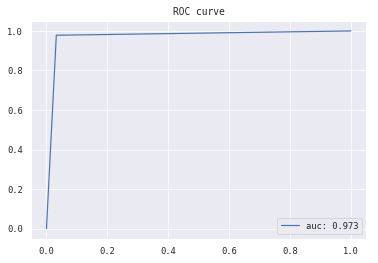

Confusion matrix :
 ----------------------------------------------------------------------------------------------------


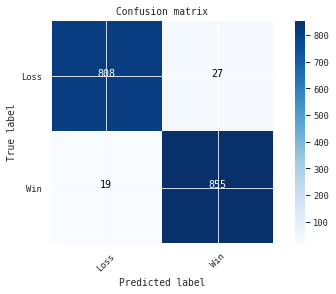

Normalized confusion matrix :
 ----------------------------------------------------------------------------------------------------


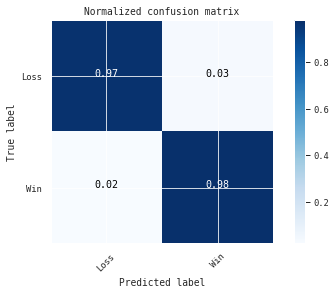

In [35]:
# Model accuracy evaluation metrics
rf_model_dict['sensitivity'], rf_model_dict['specificity'], rf_model_dict['auc'], rf_model_dict['accuracy'] = binary_class_evaluator(fitted_rf_model, x_test, y_test, elasticnet = False)

# Plot non-normalized and normalized confusion matrix
plot_confusion_matrix(fitted_rf_model, x_test, y_test, classes=['Loss', 'Win'], elasticnet = False)
plot_confusion_matrix(fitted_rf_model, x_test, y_test, classes=['Loss', 'Win'], normalize=True, elasticnet = False)

##### Feature importance evaluator

In [36]:
# Show the sorted features indicating the highest importance in predicting the target
feature_imp = pd.Series(fitted_rf_model.feature_importances_,index=x_train.columns).sort_values(ascending=False)
rf_model_dict['feature_importance'] = dict(zip(feature_imp.index, feature_imp))
feature_imp[:10]

teamtowerkills    0.266682
earnedgpm         0.123503
d                 0.094763
kpm               0.072964
a                 0.060551
teamkills         0.051410
k                 0.048666
gspd              0.047201
teambaronkills    0.030566
Encoded_fbaron    0.020332
dtype: float64

### 3.5 Comparison ML techniques

##### Creation summary table

In [37]:
# Create summary table
for key in logistic_L1penalty_model_dict.keys():
    model_summary_dict[key] = [logistic_L1penalty_model_dict[key], ridge_model_dict[key], elasticnet_model_dict[key], rf_model_dict[key]]
model_summary_table = pd.DataFrame(model_summary_dict, columns = logistic_L1penalty_model_dict.keys())
model_summary_table.rename(index={0:'Lasso', 1:'Ridge', 2:'Elasticnet', 3:'RandomForest'}, inplace = True)

# Visualize summary table
model_summary_table

,regularisation_param,sensitivity,specificity,auc,accuracy,feature_importance
Lasso,NaN,0.983982,0.976048,0.980015,0.980105,"{'teamtowerkills': 5.147349233949684, 'd': -1...."
Ridge,0.975,0.993135,0.972455,0.982795,0.983031,"{'teamtowerkills': 0.6682372630983063, 'wardki..."
Elasticnet,"{'l1_ratio': 0.01, 'alpha': 0.0439633322778549}",0.990847,0.971257,0.981052,0.981276,"{'teamtowerkills': 0.27300611869720404, 'd': -..."
RandomForest,"{'bootstrap': False, 'max_features': 'auto', '...",0.978261,0.967665,0.972963,0.973084,"{'teamtowerkills': 0.2666815328890088, 'earned..."


##### Investigate accuracy metrics

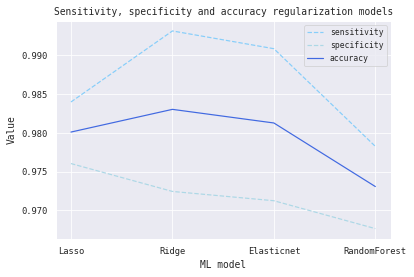

In [38]:
# Visualize a summarization of the accuracy metrics for the different ML methods
fig, ax = plt.subplots()
ax.plot(list(model_summary_table.index), model_summary_table.sensitivity, '--', label="sensitivity", color='lightskyblue')
ax.plot(list(model_summary_table.index), model_summary_table.specificity, '--', label="specificity", color='lightblue')
ax.plot(list(model_summary_table.index), model_summary_table.accuracy, label="accuracy", color='royalblue')
plt.title("Sensitivity, specificity and accuracy regularization models")
plt.ylabel('Value')
plt.xlabel('ML model')
ax.legend(loc ="best", fontsize = 8)

##### Investigate parameter coefficients

In [39]:
# Short intermediate summary
print("The number of features kept by the different techniques in the model:\n", "-"*100)
for ML in list(model_summary_table.index):
    print(ML, ": ", len(model_summary_table.feature_importance[ML]))

The number of features kept by the different techniques in the model:
 ----------------------------------------------------------------------------------------------------
Lasso :  27
Ridge :  67
Elasticnet :  67
RandomForest :  67


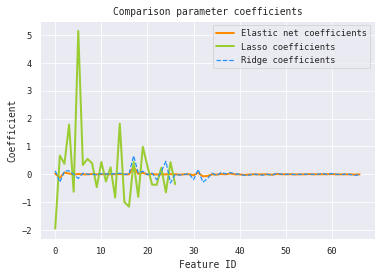

In [40]:
# Visualization of difference in coefficient estimates
plt.plot(fitted_elasticnet_model.coef_, color='darkorange', linewidth=2,
         label='Elastic net coefficients')
plt.plot(fitted_logistic_L1penalty_model.coef_[0], color='yellowgreen', linewidth=2,
         label='Lasso coefficients')
plt.plot(fitted_ridge_model.coef_[0], '--', color='dodgerblue', label='Ridge coefficients')
plt.legend(loc='best')
plt.title("Comparison parameter coefficients")
plt.ylabel('Coefficient')
plt.xlabel('Feature ID')
plt.show()

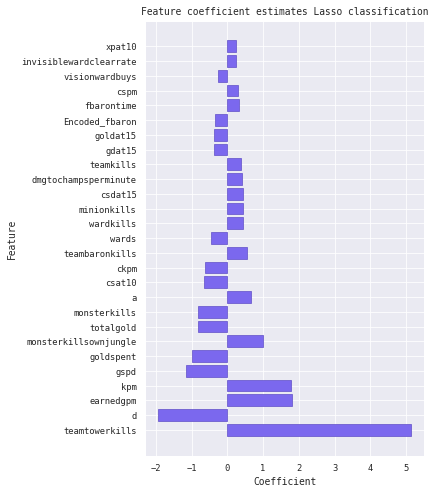

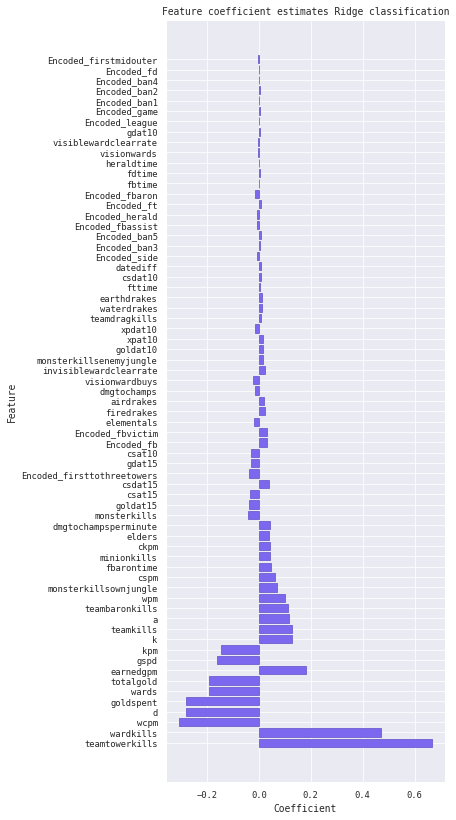

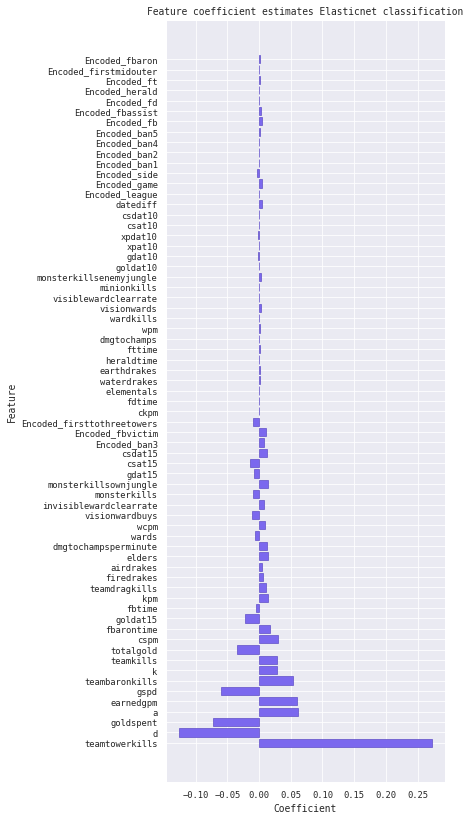

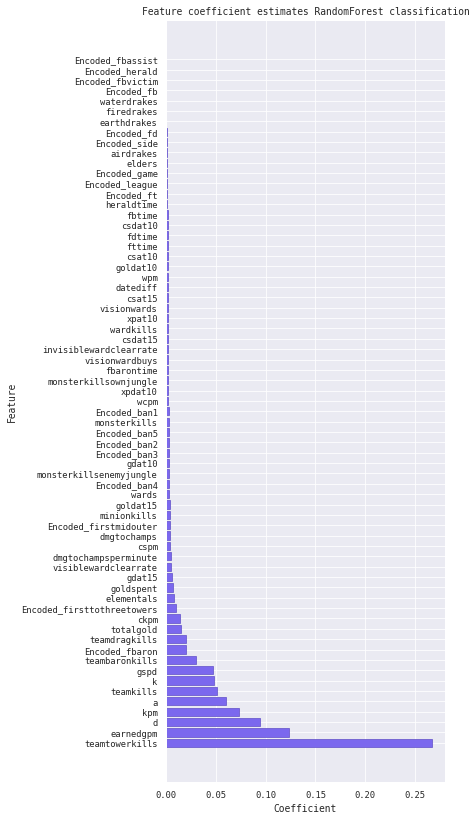

In [41]:
# Visualize feature importance (coefficient based)
for index, ML in enumerate(list(model_summary_table.index)):
    x =  np.arange(len(model_summary_table.feature_importance[ML]))
    plt.figure(figsize=(5, 8)) if index == 0 else plt.figure(figsize=(5, 14)) 
    plt.barh(x, list(model_summary_table.feature_importance[ML].values()), 
             tick_label =  list(model_summary_table.feature_importance[ML].keys()),
             color = 'mediumslateblue', 
             edgecolor = 'slateblue')
    plt.title("Feature coefficient estimates " + ML + " classification")
    plt.ylabel('Feature')
    plt.xlabel('Coefficient')
    plt.show()

## 4. Create team specific summary vectors

### 4.1 Create dataset capturing the average feature values per team
A team specific summary vector will be created by looping through all the features captured by the dataset and taking the average over all the games played by that team (for a specific feature). To have a better indication of the accuracy of the team vector another column is added at the end indicating the number of games on which the calculation is based.

In [42]:
# Extract list with the different teams
teams = list(set(data_raw.team))
team_vector_cols = list(data.columns)
team_vector_cols.append('accuracy indicator')

# Create summary vector for each team
team_info_list = []
for team in teams:
    team_vector = []
    team_subdf = data_raw[data_raw.team == team]
    # Loop through the different columns
    for col in data.columns:
        # Take the mean over column values for numerical features
        if 'Encoded' not in col:
            team_vector.append(team_subdf[col].mean())
        # Take the majority value over column values for discrete features
        else: 
            team_vector.append(RandomSampleProbDist(team_subdf[col]))
    # Add accuracy indicator
    team_vector.append(len(team_subdf))
    team_info_list.append(team_vector)
    
# Create summary dataframe
team_vector_df = pd.DataFrame(data = team_info_list, index=teams, columns=team_vector_cols)

In [43]:
# Intermediate summary
print("Summary information team vector dataframe: Team specific feature vectors are captured for", len(team_vector_df), "teams.\n")

# Extract vector accuracy information
print("The teams indicating feature vectors based on less than 10 games:\n", '-'*100)
for team, acc_ind in zip(list(team_vector_df.index), team_vector_df['accuracy indicator']):
    if acc_ind < 10:
        print(team)

Summary information team vector dataframe: Team specific feature vectors are captured for 131 teams.

The teams indicating feature vectors based on less than 10 games:
 ----------------------------------------------------------------------------------------------------
besiktas
cj entus
17 academy
pentagram
isurus gaming
oyunhizmetleri
young generation
ascension gaming
kinguin
rainbow7
virtus.pro


Overview of variable:  Accuracy indicator 


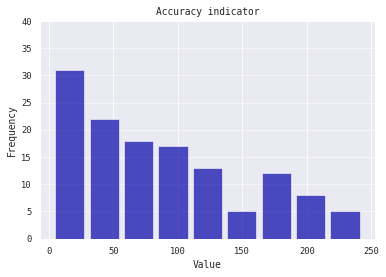

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3
Mean: 86.9466
Standard deviation: 66.0879
Median: 71
Maximal value: 243


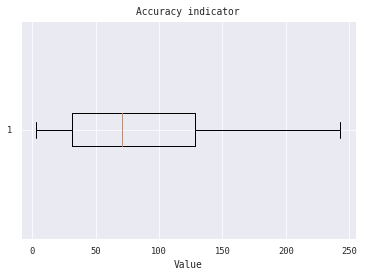

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


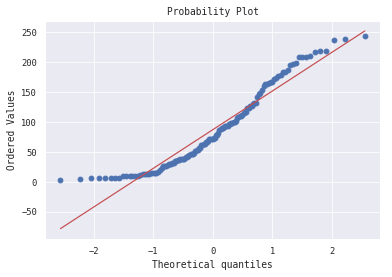

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6227
Kurtosis: -0.6871


<Figure size 432x288 with 0 Axes>

In [44]:
# Accuracy indicator distribution
SummaryNumericVar(team_vector_df['accuracy indicator'], 'Accuracy indicator')

### 4.2 Estimate team strength parameters

In [45]:
# Create dictionary to capture strength parameter information
strength_param_dict = dict()

# Extract columns not used for model fit
additional_columns = ['result', 'accuracy indicator']
strength_param_dict['accuracy indicator'] = team_vector_df['accuracy indicator']

##### Lasso classification based parameter approximation

In [46]:
# 1. Fit (trained) lasso classification model
strength_param_dict['lasso'] = [y for x, y in fitted_logistic_L1penalty_model.predict_proba(team_vector_df[selected_features_rfe])]

##### Ridge classification based parameter approximation

In [47]:
# 2. Fit ridge classification model with best regularisation parameter based on CV
additional_columns = ['result', 'accuracy indicator']
ridge = RidgeClassifier(alpha = ridge_model_dict['regularisation_param'], fit_intercept = False)
fitted_ridge = ridge.fit(x_train, y_train)
logit_trans_predictions_ridge = fitted_ridge.decision_function(team_vector_df[[x for x in data.columns if x not in additional_columns]])
strength_param_dict['ridge'] = np.exp(logit_trans_predictions_ridge) / (1 + np.exp(logit_trans_predictions_ridge))

Remark: There is no predicted probability option for the RidgeClassifier because this model is not easy to interpret as a probability model. The decision function of the RidgeClassifier model considers a logit transformation of the actual class probabilities. If decision function is greater than zero then class 1 is predicted otherwise predict class 0, corresponding to a classical logit approach. By back-transforming these predictions we can get the predicted probabilities.

##### Result averaging based parameter approximation

In [48]:
# 3. Expected outcome of the game based on team-vector averaging 
strength_param_dict['result'] = team_vector_df['result']

In [49]:
# Create dataframe of strength parameter summarization
strength_param_df = pd.DataFrame(strength_param_dict)
strength_param_df.head()

,accuracy indicator,lasso,ridge,result
galatasaray esports,27,0.074686,0.445180,0.296296
clutch gaming,93,0.096598,0.475694,0.451613
newbee,93,0.165294,0.474261,0.473118
vici gaming,123,0.009371,0.384944,0.252033
pain gaming,57,0.592378,0.504485,0.526316


### 4.3 Investigation strength parameter characteristics

Overview of variable:  lasso 


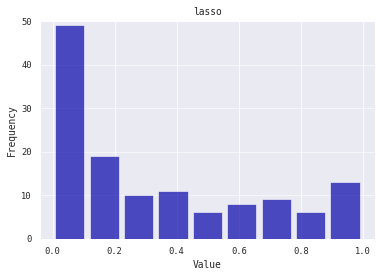

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3.766779220139921e-05
Mean: 0.3307
Standard deviation: 0.3244
Median: 0.2028
Maximal value: 0.9975373026004482


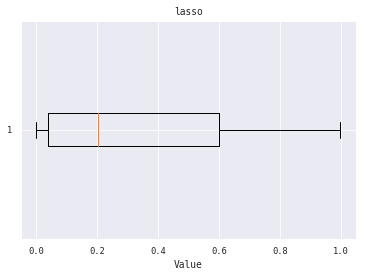

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


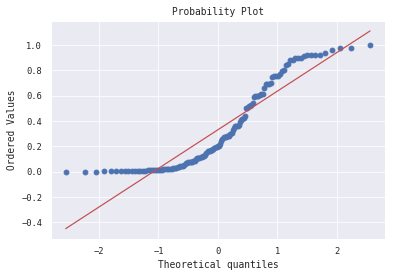

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6849
Kurtosis: -0.9652
Overview of variable:  ridge 


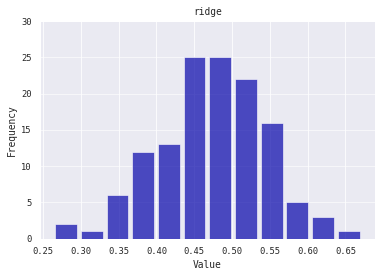

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.2635644166908092
Mean: 0.4736
Standard deviation: 0.073
Median: 0.4743
Maximal value: 0.6712326268935185


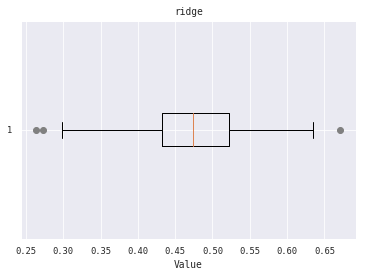

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


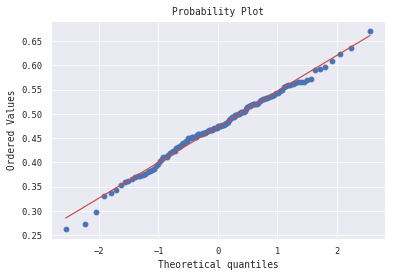

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2397
Kurtosis: 0.2351
Overview of variable:  result 


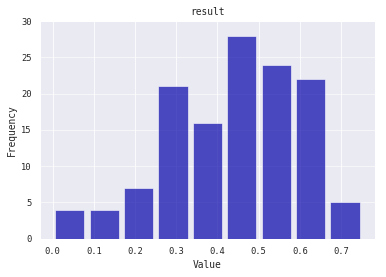

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.4396
Standard deviation: 0.1584
Median: 0.4567
Maximal value: 0.751412429378531


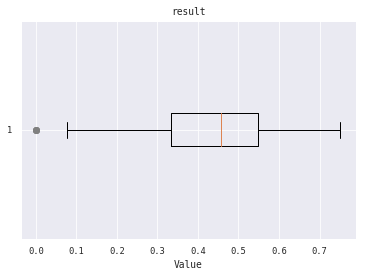

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


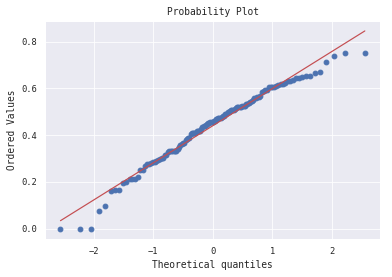

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.5209
Kurtosis: 0.0955


<Figure size 432x288 with 0 Axes>

In [50]:
# Visualisation strength parameter distributions (based on the different techniques)
for col in strength_param_df.columns[1:]:
    SummaryNumericVar(strength_param_df[col], col)

### 4.4 Write data away

In [51]:
# Save the team strength parameter data
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '.pickle', 'wb') as f:
    pickle.dump(strength_param_df, f)